# Deep learning for HKL classification
## TODO: Test for Triclinic --> if the model works for two extreme symmetry case, then it should work for intermediate symmetries as well

## Now can predict with > 95% accuracy for multi grain Laue Patterns
## If you have model save files; go to cell 45 to load and start prediction

## Pros: Impressive speed for prediction; results not dependent on the statistical descriptor (ex: correlation function or distance measurment)
## Cons: Building reliable test data can take few hours (this will significantly increase for less symmetry crystals) --> multiprocessing to reduce time

## Library import

In [51]:
# Keras library is required 
# "conda install -c conda-forge keras" for anaconda distribution
# Currently CPU calculation is more than enough. GPU not really needed

In [82]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

## Keras import
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical

## LaueTools import
import LaueTools.dict_LaueTools as dictLT
import LaueTools.findorient as FO
import LaueTools.generaltools as GT
import LaueTools.lauecore as LT
import LaueTools.CrystalParameters as CP

## Defining useful functions

In [83]:
DEG = np.pi / 180.0

def get_material_data(material_="Cu", ang_maxx = 45, step = 0.5, hkl_ref=13, hklclass=11,
                           classhkl = None):
    a, b, c, alpha, beta, gamma = dictLT.dict_Materials[material_][1]
    Gstar = CP.Gstar_from_directlatticeparams(a, b, c, alpha, beta, gamma)
    rules = dictLT.dict_Materials[material_][-1]
    
    hkl2 = GT.threeindices_up_to(hkl_ref)
    hkl2 = CP.ApplyExtinctionrules(hkl2,rules)

    query_angle = ang_maxx/2.
    angle_tol = ang_maxx/2.
    hkl1 = classhkl
    # compute square matrix containing angles
    metrics = Gstar
    H1 = hkl1
    n1 = hkl1.shape[0]
    H2 = hkl2
    n2 = hkl2.shape[0]
    
    dstar_square_1 = np.diag(np.inner(np.inner(H1, metrics), H1))
    dstar_square_2 = np.diag(np.inner(np.inner(H2, metrics), H2))
    scalar_product = np.inner(np.inner(H1, metrics), H2) * 1.0
    
    d1 = np.sqrt(dstar_square_1.reshape((n1, 1))) * 1.0
    d2 = np.sqrt(dstar_square_2.reshape((n2, 1))) * 1.0
    outy = np.outer(d1, d2)
    
    ratio = scalar_product / outy
    ratio = np.round(ratio, decimals=7)
    tab_angulardist = np.arccos(ratio) / DEG
    
    np.putmask(tab_angulardist, np.abs(tab_angulardist) < 0.001, 400)
    
    closest_angles_values = []
    for ang_ in trange(len(tab_angulardist)):
        tab_angulardist_ = tab_angulardist[ang_,:]
        angles_set = np.ravel(tab_angulardist_)  # 1D array
        sorted_ind = np.argsort(angles_set)
        sorted_angles = angles_set[sorted_ind]
        
        angle_query = angle_tol
        if isinstance(query_angle, (list, np.ndarray, tuple)):
            angle_query = query_angle[0]
        
        array_angledist = np.abs(sorted_angles - angle_query)
        pos_min = np.argmin(array_angledist)
        closest_angle = sorted_angles[pos_min]
        
        if np.abs(closest_angle - query_angle) > angle_tol:
            if angle_query > 0.5:
                pass
            print("TODO function get_material_data")
            
        condition = array_angledist <= angle_tol
        closest_index_in_sorted_angles_raw = np.where(condition)[0]
        closest_angles_values.append(np.take(sorted_angles, closest_index_in_sorted_angles_raw))
    
    codebars = []
    angbins = np.arange(0, ang_maxx+step, step)
    for i in trange(len(closest_angles_values)):
        angles = closest_angles_values[i]
        fingerprint = np.histogram(angles, bins=angbins, density=False)[0]
        ## Normalize the histogram by its maximum: simple way 
        ## Maybe better normalization is possible.. to be seen
        max_codebars = np.max(fingerprint)
        fingerprint = fingerprint/ max_codebars
        codebars.append(fingerprint)
    return codebars, angbins

## Function to simulate Laue Patterns

In [84]:
def simulatemultiplepatterns(n, key_material=None, emax=23,
                             detectorparameters=None,
                             sortintensity = False):
    nbUBs=n
    UBelemagnles = np.random.random((3,nbUBs))*360-180.
    l_tth, l_chi, l_miller_ind, l_posx, l_posy, l_E, l_intensity = [],[],[],[],[],[],[]
    
    for angle_X, angle_Y, angle_Z in UBelemagnles.T:
        UBmatrix = GT.fromelemangles_toMatrix([angle_X, angle_Y, angle_Z])
        grain = CP.Prepare_Grain(key_material, UBmatrix)

        if detectorparameters is None:
            detectorparameters = [70.182, 1039.309, 944.122, 0.747, 0.071]
            
        s_tth, s_chi, s_miller_ind, s_posx, s_posy, s_E= LT.SimulateLaue_full_np(grain, 5, emax,
                                                                                 detectorparameters,
                                                                                 pixelsize=0.079142,
                                                                                 removeharmonics=1)
        s_intensity = 1./s_E
        l_tth.append(s_tth)
        l_chi.append(s_chi)
        l_miller_ind.append(s_miller_ind)
        l_posx.append(s_posx)
        l_posy.append(s_posy)
        l_E.append(s_E)
        l_intensity.append(s_intensity)
    #flat_list = [item for sublist in l for item in sublist]
    s_tth = np.array([item for sublist in l_tth for item in sublist])
    s_chi = np.array([item for sublist in l_chi for item in sublist])
    s_miller_ind = np.array([item for sublist in l_miller_ind for item in sublist])
    s_posx = np.array([item for sublist in l_posx for item in sublist])
    s_posy = np.array([item for sublist in l_posy for item in sublist])
    s_E = np.array([item for sublist in l_E for item in sublist])
    s_intensity=np.array([item for sublist in l_intensity for item in sublist])
    
    if sortintensity:
        indsort = np.argsort(s_intensity)[::-1]
        s_tth=np.take(s_tth, indsort)
        s_chi=np.take(s_chi, indsort)
        s_miller_ind=np.take(s_miller_ind, indsort, axis=0)
        s_posx=np.take(s_posx, indsort)
        s_posy=np.take(s_posy, indsort)
        s_E=np.take(s_E, indsort)
        s_intensity=np.take(s_intensity, indsort)
    return s_tth, s_chi, s_miller_ind

In [4]:
def getpatterns_(n, material_=None,emax=23, detectorparameters=None, sortintensity = False,
                ang_maxx = 45, step = 0.5, classhkl = None, noisy_data=False, remove_peaks=False):
    codebars = []
    
    s_tth, s_chi, s_miller_ind = simulatemultiplepatterns(n, key_material=material_, emax=emax,
                                                         detectorparameters=detectorparameters,
                                                         sortintensity = sortintensity)
    if noisy_data:
        ## apply random gaussian type noise to the data (tth and chi)
        ## So adding noise to the angular distances
        ## Instead of adding noise to all HKL's ... Add to few selected HKLs
        ## Adding noise to randomly 30% of the HKLs
        indices_noise = np.random.choice(len(s_tth), int(len(s_tth)*0.3), replace=False)
        noise_ = np.random.normal(0,0.1,len(indices_noise))
        s_tth[indices_noise] = s_tth[indices_noise] + noise_
        s_chi[indices_noise] = s_chi[indices_noise] + noise_
        
    if remove_peaks:
        len_mi = np.array([iq for iq in range(len(s_miller_ind))])
        len_mi = len_mi[int(0.5*len(s_miller_ind)):]
        indices_remove = np.random.choice(len_mi, int(len(s_miller_ind)*0.1), replace=False)
        ## delete randomly selected less intense peaks
        ## to simulate real peak detection, where some peaks may not be
        ## well detected
        s_tth = np.delete(s_tth, indices_remove)
        s_chi = np.delete(s_chi, indices_remove)
        s_miller_ind = np.delete(s_miller_ind, indices_remove, axis=0)
        
    # replace all hkl class with relevant hkls
    location = []
    for k, i in enumerate(s_miller_ind):
        found = False
        for l, j in enumerate(classhkl):
            isok = commonclass(i,j,material_)
            if isok:
                location.append(l)
                found = True
                break
        if not found:
            location.append(-100) ## If this occurs then increase maximum HKL index
    
    allspots_the_chi = np.transpose(np.array([s_tth/2., s_chi]))
    tabledistancerandom = np.transpose(GT.calculdist_from_thetachi(allspots_the_chi, allspots_the_chi))

    angbins = np.arange(0,ang_maxx+step,step)
    for i in range(len(tabledistancerandom)):
        angles = tabledistancerandom[i]
        angles = np.delete(angles, i)# removing the self distance
        fingerprint = np.histogram(angles, bins=angbins, density=False)[0]
        ## same normalization as before
        max_codebars = np.max(fingerprint)
        fingerprint = fingerprint/ max_codebars
        codebars.append(fingerprint)
    return codebars, angbins, s_miller_ind, location

In [85]:
# Other helper funtions to limit the HKL indices
def spots_in_ROI(s_tth,s_chi,centerscattering=[70/2.,0],anglefromcenter=10.):
    """ return spot indices of spot lying in a given direction around a central direction"""
    # finding central spots
    s_the = s_tth/2.
    exp_s = np.array([s_the,s_chi]).T
    dist=GT.calculdist_from_thetachi(np.array([centerscattering]),exp_s).flatten()
    conddistin = dist<=anglefromcenter
    condtth = s_tth<70
    cond = np.logical_and(conddistin,condtth)
    #cond = np.logical_and(dist>anglefromcenter,condtth)
    spots_ix= np.where(cond)[0]
    return spots_ix

def classhkl_cubic(hkl):
    """ unique representation of hkl for cubic case
    """
    return sorted([abs(int(ind)) for ind in hkl])

def commonclass(hkl1, hkl2, material_):
    """ test if hkl1 and hkl2 belong to the same class"""
    if material_ == "Cu":
        cond1 = classhkl_cubic(hkl1)==classhkl_cubic(hkl2)
        cond2 = np.sum(np.cross(classhkl_cubic(hkl1),classhkl_cubic(hkl2))**2)==0.
    return cond1 or cond2

## Function to prepare laue patterns with required inputs

In [6]:
def prepare_LP(nbgrains, material_,verbose,plotLauePattern):
    s_tth, s_chi, s_miller_ind = simulatemultiplepatterns(nbgrains,key_material=material_,sortintensity=True)
    spots_in_center = spots_in_ROI(s_tth,s_chi)
    if verbose:
        print('nb of central spots',len(spots_in_center))
        print('Central spots',spots_in_center)
    
    if plotLauePattern:
        figlaue, axlaue= plt.subplots()
        axlaue.scatter(s_tth,s_chi)
        axlaue.scatter(s_tth[spots_in_center],s_chi[spots_in_center], c="r")
        axlaue.set_title('nb matrices: %d, nb spots : %d'%(nbgrains,len(s_tth)))
    # considering all spots
    allspots_the_chi = np.transpose(np.array([s_tth/2., s_chi]))
    #print("Calculating all mutual angular distances of selected spots...")
    tabledistancerandom = np.transpose(GT.calculdist_from_thetachi(allspots_the_chi, allspots_the_chi))
    # ground truth
    hkl_sol = s_miller_ind
    return tabledistancerandom, hkl_sol, spots_in_center

## Function to generate the test data for Neural network

In [7]:
def load_dataset(material_="Cu", hkl_max_identify = 12, ang_maxx=18.,step=0.1, mode=0, 
                 nb_grains=1,grains_nb_simulate=100, data_realism = False): 
    """
    Only for Cubic symmetry now.... To extend for Zirconia
    """
    n = hkl_max_identify
    classhkl = []
    if material_ == "Cu":
        for i in range(1,n+1):
            for j in range(0,i+1):
                for k in range(0,j+1):
                    classhkl.append([i,j,k])
        classhkl = np.array(classhkl)
    rules = dictLT.dict_Materials[material_][-1]
    classhkl = CP.ApplyExtinctionrules(classhkl, rules)
    classhkl = CP.FilterHarmonics_2(classhkl)  
    classhkl = np.array([classhkl_cubic(hkl) for hkl in classhkl])
    
    codebars, angbins = get_material_data(material_ = material_, ang_maxx = ang_maxx, step = step, \
                                               hkl_ref=n, hklclass=n, classhkl=classhkl)
    cb = np.array(codebars)
    mi = classhkl
    loc = np.array([ij for ij in range(len(classhkl))])
    
    if mode == 0:
        # Idea 1 Just generate a dataset having an exact idea of how many grains
        for i in trange(grains_nb_simulate):
            codebars, angbins, s_miller_ind, location = getpatterns_(nb_grains, material_=material_,
                                                                    sortintensity = True,
                                                                    ang_maxx = ang_maxx, step = step,
                                                                    classhkl = classhkl)
            cb = np.vstack((cb, np.array(codebars)))
            mi = np.vstack((mi, np.array(s_miller_ind)))
            loc = np.hstack((loc, np.array(location)))
    elif mode == 1:
        # Idea 2 Or generate a database upto n grain LP
        for i in trange(nb_grains):
            for j in range(grains_nb_simulate):
                if data_realism:
                    ## three types of data augmentation to mimic reality ?
                    if j < grains_nb_simulate*0.25:
                        noisy_data = False
                        remove_peaks = False
                    elif (j > grains_nb_simulate*0.25) and (j < grains_nb_simulate*0.5):
                        noisy_data = True
                        remove_peaks = False
                    elif (j > grains_nb_simulate*0.5) and (j < grains_nb_simulate*0.75):
                        noisy_data = False
                        remove_peaks = True
                    elif (j > grains_nb_simulate*0.75):
                        noisy_data = True
                        remove_peaks = True
                else:
                    noisy_data = False
                    remove_peaks = False
                    
                codebars, angbins, s_miller_ind, location = getpatterns_(i+1, material_=material_,
                                                                        sortintensity = True,
                                                                        ang_maxx = ang_maxx, step = step,
                                                                        classhkl = classhkl, 
                                                                        noisy_data=noisy_data, 
                                                                        remove_peaks=remove_peaks)
                cb = np.vstack((cb, np.array(codebars)))
                mi = np.vstack((mi, np.array(s_miller_ind)))
                loc = np.hstack((loc, np.array(location)))
        
    print("Min HKL class: ",np.min(loc))
    print("Max HKL class: ",np.max(loc))
    print("Total HKL class: ",len(classhkl))
    
    if np.min(loc) == -100:
        print("Some HKL equivalent could not be found; check before continuing")
        return
    
    temp_ = to_categorical(loc)
    trainX = cb
    trainy = temp_
    return trainX, trainy, classhkl, angbins

## Define the architecture and user defined loss function of the Neural Network

In [8]:
from keras import backend as K
def categorical_focal_loss(alpha, gamma=2.):
    alpha = np.array(alpha, dtype=np.float32)
    def categorical_focal_loss_fixed(y_true, y_pred):
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)
        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))
    return categorical_focal_loss_fixed

def model_arch(trainX, trainy):
    """
    Very simple and straight forward Neural Network with few hyperparameters
    straighforward RELU activation strategy with cross entropy to identify the HKL
    """
    n_bins, n_outputs = trainX.shape[1], trainy.shape[1]
    alpha = np.ones(n_outputs) * 0.25
    model = Sequential()
    model.add(keras.Input(shape=(n_bins,)))
    model.add(Dense(n_bins, activation='relu'))
    #model.add(Dropout(0.1)) ## Adding dropout as we introduce some uncertain data with noise
    model.add(Dense((n_bins), activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense((n_bins)//2, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss=[categorical_focal_loss(alpha, gamma=2.)], optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Lets train the model

## generate data for model learning

In [10]:
## we generate Cu HKL's upto 12 indices with max angle of 30° and step of 0.1°
# mode 0: When the user is certain regarding the number of grains present in the Laue Pattern; 
#         having this will speed up the data generation process
# when mode 0 is selected: define nb_grains i.e. the number of grains one expects in a LP

# mode 1: When the user is not certain regarding the number of grains present in the Laue Pattern; 
# when mode 1 is selected: define nb_grains i.e. the maximum number of grains a LP can have
# we simulate sequentailly LP's upto nb_grains to increase our training dataset
# when mode 1: grains_nb_simulate should be provided --> 100 grains per nb_grains is a good start point;
# increasing this will slow the data generation process but will give more accuracy on the prediction

# we train a model guessing that we can have upto 5 grains or less in an observed Laue Pattern
## 5 grains with grains_nb_simulate = 100 takes 1min30sec to generate the data
## 5 grains with grains_nb_simulate = 1000 takes 25min to generate the data
## 10 grains with grains_nb_simulate = 1000 takes ~2hours
############ USER INPUT
material_="Cu"
hkl_max_identify = 12
maximum_angle_to_search = 90 ## 2theta
step_for_binning = 0.1
mode_of_analysis = 1
nb_grains_per_lp = 10
grains_nb_simulate = 500
save_data = False
load_data = False
generate_data = False
## data_realism : whether to include noisy data and some spots missing LP or not
############ GENERATING TRAINING DATA

if load_data:
    import _pickle as cPickle
    with open(r"data/hkl_training_data.pickle", "rb") as input_file:
        trainX, trainy, testX, testy, classhkl, angbins = cPickle.load(input_file)
    print(trainX.shape)
    print(trainy.shape)
    print(classhkl.shape)
    print("MOVE DIRECTLY TO CELL 49 to load model and predict")
elif generate_data:
    trainX, trainy, classhkl, angbins = load_dataset(material_=material_, 
                                                     hkl_max_identify = hkl_max_identify, 
                                                     ang_maxx=maximum_angle_to_search,
                                                     step=step_for_binning, 
                                                     mode=mode_of_analysis, 
                                                     nb_grains=nb_grains_per_lp,
                                                     grains_nb_simulate=grains_nb_simulate,
                                                     data_realism = True)

    ############ GENERATING TESTING DATA
    testX, testy, classhkl, _ = load_dataset(material_=material_, 
                                                     hkl_max_identify = hkl_max_identify, 
                                                     ang_maxx=maximum_angle_to_search,
                                                     step=step_for_binning, 
                                                     mode=mode_of_analysis, 
                                                     nb_grains=nb_grains_per_lp,
                                                     grains_nb_simulate=grains_nb_simulate//4,
                                                     data_realism = False)

    if save_data:
        import _pickle as cPickle
        with open(r"hkl_training_data.pickle", "wb") as output_file:
            cPickle.dump([trainX, trainy, testX, testy, classhkl, angbins], output_file)

(1173874, 900)
(1173874, 96)
(96, 3)


## Check class imbalance

## Let's train the model

In [11]:
import collections
temp_ = [np.where(r==1)[0][0] for r in trainy]
counter=collections.Counter(temp_)
print("Class ID and frequency; check for data imbalance and select appropriate LOSS function for training the model")
print(counter)

Class ID and frequency; check for data imbalance and select appropriate LOSS function for training the model
Counter({9: 78312, 15: 61105, 19: 53100, 21: 45379, 4: 45333, 6: 43730, 5: 41576, 7: 41347, 3: 39886, 22: 38910, 29: 37317, 10: 36697, 8: 35741, 11: 34729, 14: 32504, 13: 32184, 12: 30818, 37: 28902, 18: 26746, 16: 25302, 20: 24969, 31: 24166, 38: 22698, 2: 22109, 27: 20988, 28: 20545, 39: 18236, 17: 16085, 36: 15900, 0: 15509, 50: 15096, 32: 14815, 30: 13606, 24: 12891, 23: 12118, 48: 10121, 25: 9838, 1: 8694, 62: 8442, 49: 8240, 41: 7798, 61: 5521, 26: 5444, 51: 4644, 42: 4493, 40: 3801, 34: 3601, 52: 3255, 63: 2940, 64: 2745, 33: 2679, 81: 893, 53: 630, 82: 406, 65: 175, 43: 125, 35: 1, 44: 1, 45: 1, 46: 1, 47: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1})


In [45]:
##### MODEL CONSTRUCTION
model = model_arch(trainX, trainy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 900)               810900    
_________________________________________________________________
dense_9 (Dense)              (None, 900)               810900    
_________________________________________________________________
dense_10 (Dense)             (None, 450)               405450    
_________________________________________________________________
dense_11 (Dense)             (None, 96)                43296     
Total params: 2,070,546
Trainable params: 2,070,546
Non-trainable params: 0
_________________________________________________________________


In [46]:
############ USER INPUT
# try varying batch size and epochs
epochs = 1
batch_size = 25
verbose = 1
######### TRAIN THE DATA
stats_model = model.fit(trainX, trainy, epochs=epochs, 
                        batch_size=batch_size, shuffle=1,
                        validation_data=(testX, testy),
                        verbose=verbose)

Epoch 1/5
12821/12821 [==============================] - 107s 8ms/step - loss: 0.1607 - accuracy: 0.9610 - val_loss: 0.1187 - val_accuracy: 0.9719
Epoch 2/5
12821/12821 [==============================] - 122s 10ms/step - loss: 0.0863 - accuracy: 0.9804 - val_loss: 0.1202 - val_accuracy: 0.9757
Epoch 3/5
12821/12821 [==============================] - 122s 10ms/step - loss: 0.0695 - accuracy: 0.9849 - val_loss: 0.1053 - val_accuracy: 0.9798
Epoch 4/5
12821/12821 [==============================] - 99s 8ms/step - loss: 0.0633 - accuracy: 0.9873 - val_loss: 0.1243 - val_accuracy: 0.9803
Epoch 5/5
12821/12821 [==============================] - 97s 8ms/step - loss: 0.0555 - accuracy: 0.9889 - val_loss: 0.1353 - val_accuracy: 0.9797


## Plot the losses and accuracy of Training

Training Accuracy:  0.9889113306999207
Training Loss:  0.05552557483315468
Validation Accuracy:  0.9797260165214539
Validation Loss:  0.13530297577381134


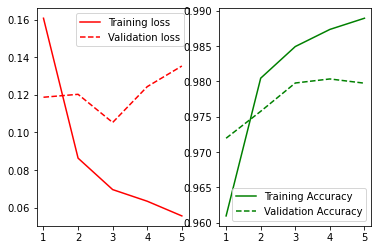

In [47]:
print( "Training Accuracy: ", stats_model.history['accuracy'][-1])
print( "Training Loss: ", stats_model.history['loss'][-1])
print( "Validation Accuracy: ", stats_model.history['val_accuracy'][-1])
print( "Validation Loss: ", stats_model.history['val_loss'][-1])

epochs = range(1, len(model.history.history['loss']) + 1)
fig, ax = plt.subplots(1,2)
ax[0].plot(epochs, model.history.history['loss'], 'r', label='Training loss')
ax[0].plot(epochs, model.history.history['val_loss'], 'r', ls="dashed", label='Validation loss')
ax[0].legend()
ax[1].plot(epochs, model.history.history['accuracy'], 'g', label='Training Accuracy')
ax[1].plot(epochs, model.history.history['val_accuracy'], 'g', ls="dashed", label='Validation Accuracy')
ax[1].legend()

## Save model config and weights

In [48]:
#%% Save model config and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("my_model.h5")
print("Saved model to disk")

Saved model to disk


## Load model weights for prediction

In [88]:
from keras.models import model_from_json
# load json and create model
json_file = open(r"data\model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

load_weights = r"data\my_model.h5"
model.load_weights(load_weights)
print("Model built and weights are loaded")

Model built and weights are loaded


# Multi grain Laue Pattern Prediction

## single prediction 

In [89]:
import time

nbgrains = 5 ## Increase the number of grains to see how accuracy changes
material_ = "Cu"
verbose = 0

tabledistancerandom, hkl_sol, spots_in_center = prepare_LP(nbgrains, 
                                                            material_,
                                                            verbose,
                                                            plotLauePattern=False)
if len(spots_in_center) == 0:
    print("No spots in center")
    
spots_in_center = [sp for sp in range(len(tabledistancerandom))]# take all spots in Laue pattern
    
start_time = time.time()
count_good = 0
count_bad = 0
codebars_all = []
print("Spots in center: ",len(spots_in_center))
for i in spots_in_center: ## identify the center HKL spots 
    spotangles = tabledistancerandom[i]
    spotangles = np.delete(spotangles, i)# removing the self distance
    codebars = np.histogram(spotangles, bins=angbins)[0]
    ## normalize the same way as training data
    max_codebars = np.max(codebars)
    codebars = codebars/ max_codebars
    codebars_all.append(codebars)
## reshape for the model
codebars = np.array(codebars_all)
## Do prediction of all spots at once
prediction = model.predict(codebars)
class_predicted = np.argmax(prediction, axis = 1)
## verify prediction (Assuming we dont know HKL solution)
for i, gg in enumerate(class_predicted):
    #if prediction[i,gg] > 0.9:
    #    isgoodprediction = commonclass(classhkl[gg],hkl_sol[i],material_)
    #    if isgoodprediction:
    #        count_good += 1
    #    else:
    #        count_bad += 1

    isgoodprediction = commonclass(classhkl[gg],hkl_sol[i],material_)
    if isgoodprediction:
        count_good += 1
    else:
        count_bad += 1
print("Total spots attempted:",len(spots_in_center))
print("Total Good prediction:",count_good)
print("Total Bad prediction:",count_bad)
end_time = time.time()
print("Took "+ str(end_time-start_time)+" seconds to load and predict all spots in one Laue Pattern")

Spots in center:  219
Total spots attempted: 219
Total Good prediction: 218
Total Bad prediction: 1
Took 0.08892321586608887 seconds to load and predict all spots in one Laue Pattern


## Batch prediction to get some stats

In [81]:
nbgrains = 5
material_ = "Cu"
verbose = 0
nbtestspots = 0
nb_goods = 0
nb_wrongs = 0
bad_prediction_hkl = []

for _ in trange(100):
    tabledistancerandom, hkl_sol, spots_in_center = prepare_LP(nbgrains, 
                                                                material_,
                                                                verbose,
                                                                plotLauePattern=False)
    nbtestspots = nbtestspots + len(spots_in_center)
    for i in spots_in_center: ## identify the center HKL spots 
        spotangles = tabledistancerandom[i]
        spotangles = np.delete(spotangles, i)# removing the self distance
        codebars = np.histogram(spotangles, bins=angbins)[0]
        
        max_codebars = np.max(codebars)
        codebars = codebars/ max_codebars
        codebars = codebars.reshape((1,len(codebars)))
        
        prediction = model.predict(codebars)
        class_predicted = np.argmax(prediction, axis = 1)
        
        ## verify prediction (Assuming we dont know HKL solution)
        if prediction[0,class_predicted] > 0.9:
            isgoodprediction = commonclass(classhkl[class_predicted][0],hkl_sol[i],material_)
        else:
            continue
            
        if isgoodprediction:
            nb_goods += 1
        elif not isgoodprediction:
            nb_wrongs += 1
            bad_prediction_hkl.append((classhkl[class_predicted][0], hkl_sol[i]))
            
        if verbose:
            print("Actual HKL is "+ str(hkl_sol[i]))
            print("Predicted HKL is "+ str(classhkl[class_predicted][0]))
            print('goodprediction ',isgoodprediction)
            print("**********************************")
        
print("***********")        
print('Total Prediction: ',nbtestspots) 
print('GOOD Prediction: ',nb_goods)    
print('BAD Prediction (in >90% Good predictions): ',nb_wrongs) 


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]

***********
Total Prediction:  527
GOOD Prediction:  527
BAD Prediction (in >90% Good predictions):  0
